# 程序说明
时间：2016年11月17日

说明：通过在输入空间的梯度上升，可视化VGG16的滤波器。


## 1.加载keras模块

In [1]:
from __future__ import print_function
from scipy.misc import imsave
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import time
from keras.applications import vgg16
from keras import backend as K

Using TensorFlow backend.


## 2.变量初始化

In [2]:
# 对于每个滤波器，生成图像的维度
img_width = 128
img_height = 128

# 我们想去可视化层的名字
# (看模型定义在 keras/applications/vgg16.py)
layer_name = 'block5_conv1'

#### 工具类函数将张量转换为有效图像

In [3]:
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_dim_ordering() == 'th':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

## 4.建立模型
### 调用预训练的VGG16模型

In [4]:
# 使用ImageNet的权重，构造VGG16网络
model = vgg16.VGG16(weights='imagenet', include_top=False)
print('Model loaded.')

Model loaded.


### 打印模型

In [5]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, None, None, 3) 0                                            
____________________________________________________________________________________________________
block1_conv1 (Convolution2D)     (None, None, None, 64)1792        input_1[0][0]                    
____________________________________________________________________________________________________
block1_conv2 (Convolution2D)     (None, None, None, 64)36928       block1_conv1[0][0]               
____________________________________________________________________________________________________
block1_pool (MaxPooling2D)       (None, None, None, 64)0           block1_conv2[0][0]               
___________________________________________________________________________________________

### 为输入图像定义一个placeholder

In [6]:
input_img = model.input

### 用一个字典layer_dict存放每一层

In [7]:
layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])

In [8]:
print(layer_dict.keys())

['block4_pool', 'block1_pool', 'block4_conv1', 'block2_conv1', 'block2_conv2', 'block4_conv2', 'block4_conv3', 'block2_pool', 'block5_conv3', 'block5_conv2', 'block5_conv1', 'block3_pool', 'block1_conv2', 'block1_conv1', 'block3_conv1', 'block3_conv3', 'block3_conv2', 'block5_pool']


In [9]:
def normalize(x):
    # 效用函数通过其L2范数标准化张量
    return x / (K.sqrt(K.mean(K.square(x))) + 1e-5)

## 5.提取滤波器
通过梯度上升，修改输入图像，使得滤波器的激活最大化。这是的输入图像就是我们要可视化的滤波器。

In [10]:
kept_filters = []
for filter_index in range(0, 200):
    # 我们只扫描前200个滤波器，
    # 但实际上有512个
    print('Processing filter %d' % filter_index)
    start_time = time.time()

    # 我们构建一个损耗函数，使所考虑的层的第n个滤波器的激活最大化
    layer_output = layer_dict[layer_name].output
    if K.image_dim_ordering() == 'th':
        loss = K.mean(layer_output[:, filter_index, :, :])
    else:
        loss = K.mean(layer_output[:, :, :, filter_index])

    # 我们计算输入图像的梯度与这个损失
    grads = K.gradients(loss, input_img)[0]

    # 归一化技巧：我们规范化梯度
    grads = normalize(grads)

    # 此函数返回给定输入图像的损耗和梯度
    iterate = K.function([input_img], [loss, grads])

    # 梯度上升的步长
    step = 1.

    # 我们从带有一些随机噪声的灰色图像开始
    if K.image_dim_ordering() == 'th':
        input_img_data = np.random.random((1, 3, img_width, img_height))
    else:
        input_img_data = np.random.random((1, img_width, img_height, 3))
    input_img_data = (input_img_data - 0.5) * 20 + 128

    # 我们运行梯度上升20步
    for i in range(20):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step

        print('Current loss value:', loss_value)
        if loss_value <= 0.:
            # 一些过滤器陷入0，我们可以跳过它们
            break

    # 解码所得到的输入图像
    if loss_value > 0:
        img = deprocess_image(input_img_data[0])
        kept_filters.append((img, loss_value))
    end_time = time.time()
    print('Filter %d processed in %ds' % (filter_index, end_time - start_time))

Processing filter 0
Current loss value: 11.0649
Current loss value: 27.6871
Current loss value: 45.884
Current loss value: 62.1681
Current loss value: 81.7813
Current loss value: 97.4688
Current loss value: 121.873
Current loss value: 141.359
Current loss value: 165.605
Current loss value: 186.994
Current loss value: 215.054
Current loss value: 241.564
Current loss value: 266.372
Current loss value: 288.497
Current loss value: 313.31
Current loss value: 338.803
Current loss value: 363.436
Current loss value: 387.503
Current loss value: 416.041
Current loss value: 437.538
Filter 0 processed in 2s
Processing filter 1
Current loss value: 0.0756313
Current loss value: 11.7422
Current loss value: 31.931
Current loss value: 54.8602
Current loss value: 77.8458
Current loss value: 98.8899
Current loss value: 122.782
Current loss value: 151.123
Current loss value: 186.685
Current loss value: 226.222
Current loss value: 280.84
Current loss value: 338.207
Current loss value: 408.952
Current loss 

In [11]:
# 我们将在8 x 8网格上选择最好的64个滤波器。
n = 8

# 具有最高损失的过滤器被假定为更好看。
# 我们将只保留前64个过滤器。
kept_filters.sort(key=lambda x: x[1], reverse=True)
kept_filters = kept_filters[:n * n]

In [12]:
# 构建一张黑色的图片，有足够的空间
# 我们的尺寸为128 x 128的8 x 8过滤器，中间有5px的边距
margin = 5
width = n * img_width + (n - 1) * margin
height = n * img_height + (n - 1) * margin
stitched_filters = np.zeros((width, height, 3))

In [13]:
# 使用我们保存的过滤器填充图片
for i in range(n):
    for j in range(n):
        img, loss = kept_filters[i * n + j]
        stitched_filters[(img_width + margin) * i: (img_width + margin) * i + img_width,
                         (img_height + margin) * j: (img_height + margin) * j + img_height, :] = img

## 6.显示滤波器

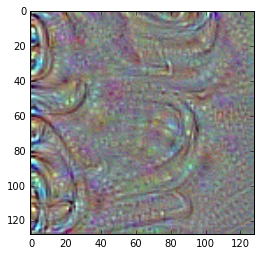

In [15]:
plt.imshow(img)
plt.show()

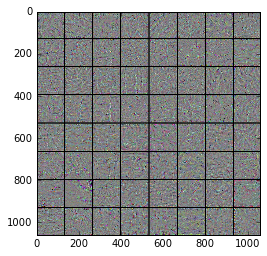

In [14]:
plt.imshow(stitched_filters)
plt.show()

In [17]:
# 保存结果
imsave('data/stitched_filters_%dx%d.png' % (n, n), stitched_filters)